1. Import the Required Libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2. Load the Image Training and Validation Datasets

i. Get the Image Dataset Paths

In [17]:
train_dataset_path = r'D:\dungnd\data\Folder\train'
validation_dataset_path = r'D:\dungnd\data\Folder\val'

ii. Load Image Datasets and Apply Augmentations

In [18]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
BATCH_SIZE = 32

Loading the training dataset and applying augmentations on it.

In [19]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 4452 images belonging to 6 classes.


Loading the validation dataset.

In [20]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 1271 images belonging to 6 classes.


iii. Get the Label Mappings

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [21]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : anhgoc
1 : catghep
2 : doimau
3 : saochep
4 : tutanh
5 : xoay


3. Plotting Sample Training Images

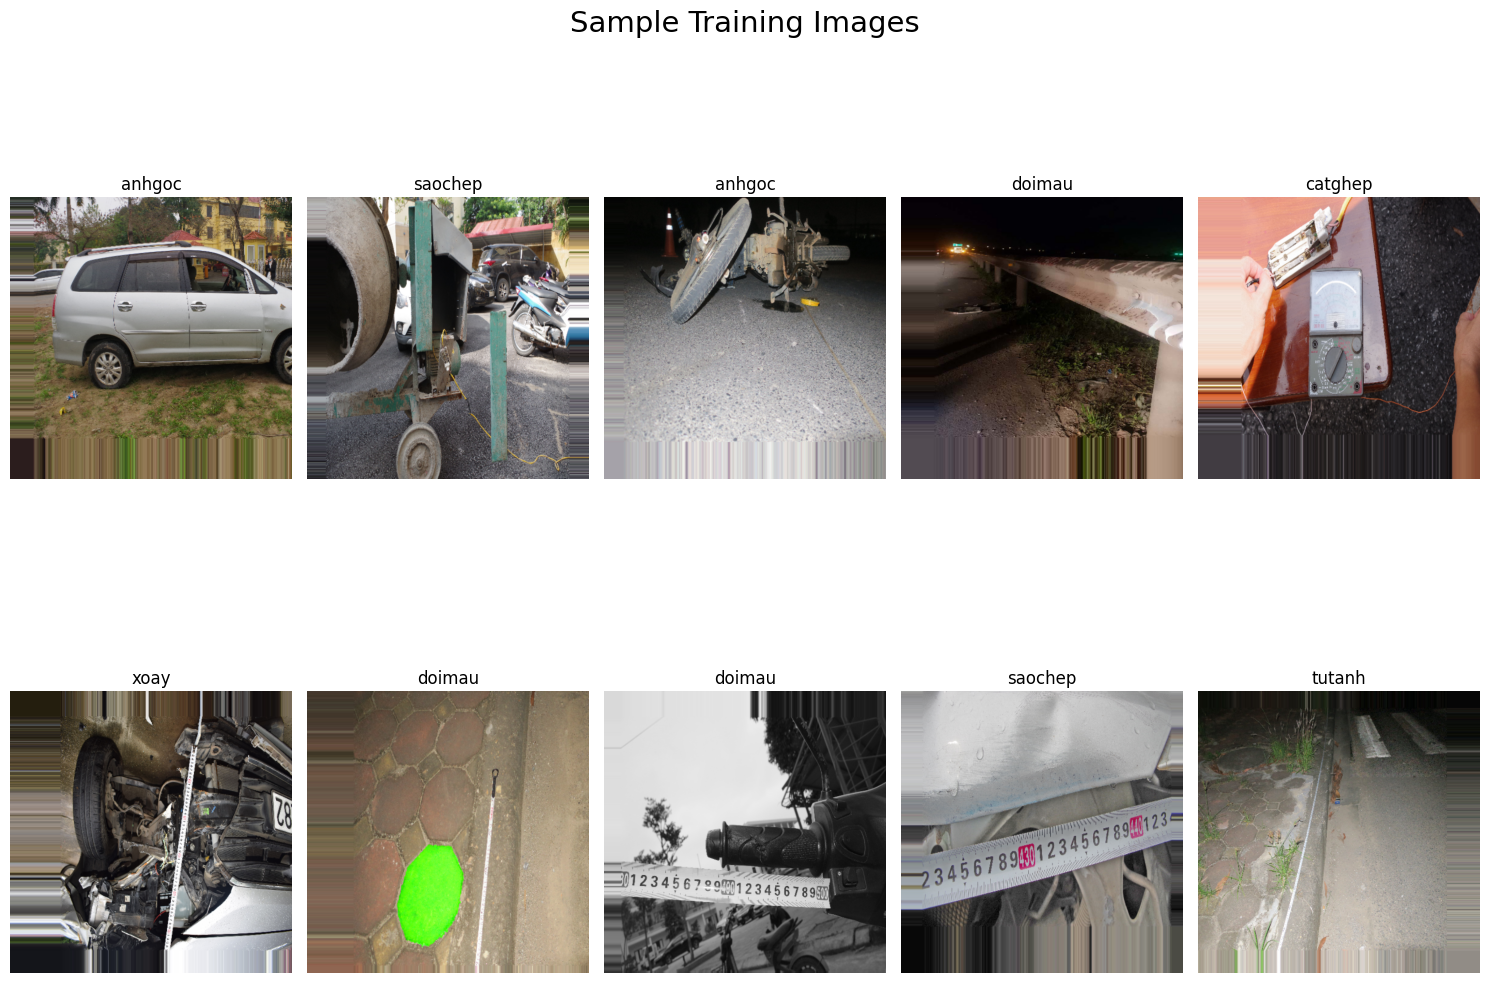

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

4. Training a CNN Model

i. Create a CNN Model

In [23]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])
    
    return model

model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 508, 508, 128)     9728      
                                                                 
 activation_6 (Activation)   (None, 508, 508, 128)     0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 254, 254, 128)     0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 254, 254, 128)     512       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 252, 64)      73792     
                                                                 
 activation_7 (Activation)   (None, 252, 252, 64)     

ii. Defining Callbacks  
Reduce Learning Rate on Plateau is used to reduce the learning rate when a metric has stopped improving.  
Defining the Optimizer  
Compile the Model  
Training the Model 

In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])
checkpoint_filepath = 'D:\\dungnd\\GraduationProject\\checkpoint\\usb_data_checkpoint\\model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

history = model.fit(train_generator, epochs=80, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr, checkpoint_cb])

Epoch 1/80
140/140 - 1579s - loss: 31.4675 - accuracy: 0.1806 - val_loss: 18.5447 - val_accuracy: 0.1723 - lr: 0.0010 - 1579s/epoch - 11s/step
Epoch 2/80
140/140 - 1457s - loss: 6.2229 - accuracy: 0.1646 - val_loss: 6.1190 - val_accuracy: 0.1629 - lr: 0.0010 - 1457s/epoch - 10s/step
Epoch 3/80
140/140 - 1574s - loss: 2.0962 - accuracy: 0.1761 - val_loss: 4.0769 - val_accuracy: 0.1817 - lr: 0.0010 - 1574s/epoch - 11s/step
Epoch 4/80
140/140 - 1461s - loss: 1.8530 - accuracy: 0.1685 - val_loss: 2.1441 - val_accuracy: 0.1613 - lr: 0.0010 - 1461s/epoch - 10s/step
Epoch 5/80
140/140 - 1526s - loss: 1.8323 - accuracy: 0.1781 - val_loss: 1.8257 - val_accuracy: 0.1833 - lr: 0.0010 - 1526s/epoch - 11s/step
Epoch 6/80
140/140 - 1596s - loss: 1.8143 - accuracy: 0.1725 - val_loss: 1.8216 - val_accuracy: 0.1857 - lr: 0.0010 - 1596s/epoch - 11s/step
Epoch 7/80
140/140 - 1597s - loss: 1.8121 - accuracy: 0.1788 - val_loss: 1.8538 - val_accuracy: 0.1825 - lr: 0.0010 - 1597s/epoch - 11s/step
Epoch 8/80


5. Plotting the Model Metrics

i. Plotting training and validation accuracy, loss and learning rate

In [25]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

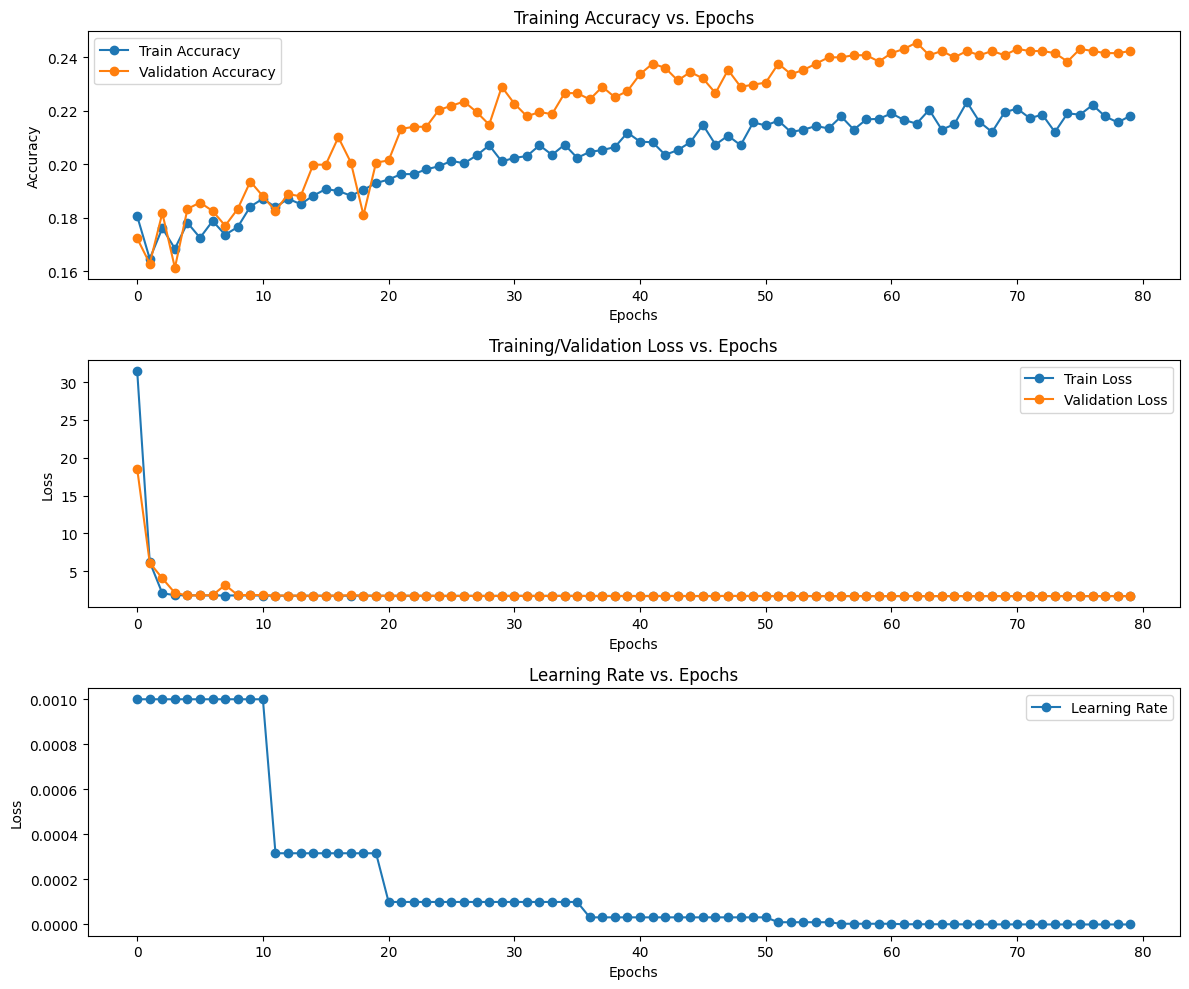

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [13]:
model.save_weights(r'D:\dungnd\GraduationProject\checkpoint\usb_data_checkpoint\model_weights.h5')

ii. Print report

In [38]:
from sklearn.metrics import classification_report

# Predict on validation data
predictions = model.predict(validation_generator)

# Get the class with the highest probability as the predicted class
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)

40/40 [==============================] - 226s 6s/step
              precision    recall  f1-score   support

      anhgoc       0.19      0.02      0.03       192
     catghep       0.17      0.67      0.28       220
      doimau       0.17      0.09      0.12       223
     saochep       0.50      0.00      0.01       207
      tutanh       0.18      0.23      0.20       220
        xoay       0.00      0.00      0.00       209

    accuracy                           0.17      1271
   macro avg       0.20      0.17      0.11      1271
weighted avg       0.20      0.17      0.11      1271



6. Testing the Model on Test Set

In [27]:
test_dataset = r'D:\dungnd\data\Folder\test'
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 641 images belonging to 6 classes.


7. Model Prediction on the Test Dataset

21/21 [==============================] - 140s 7s/step


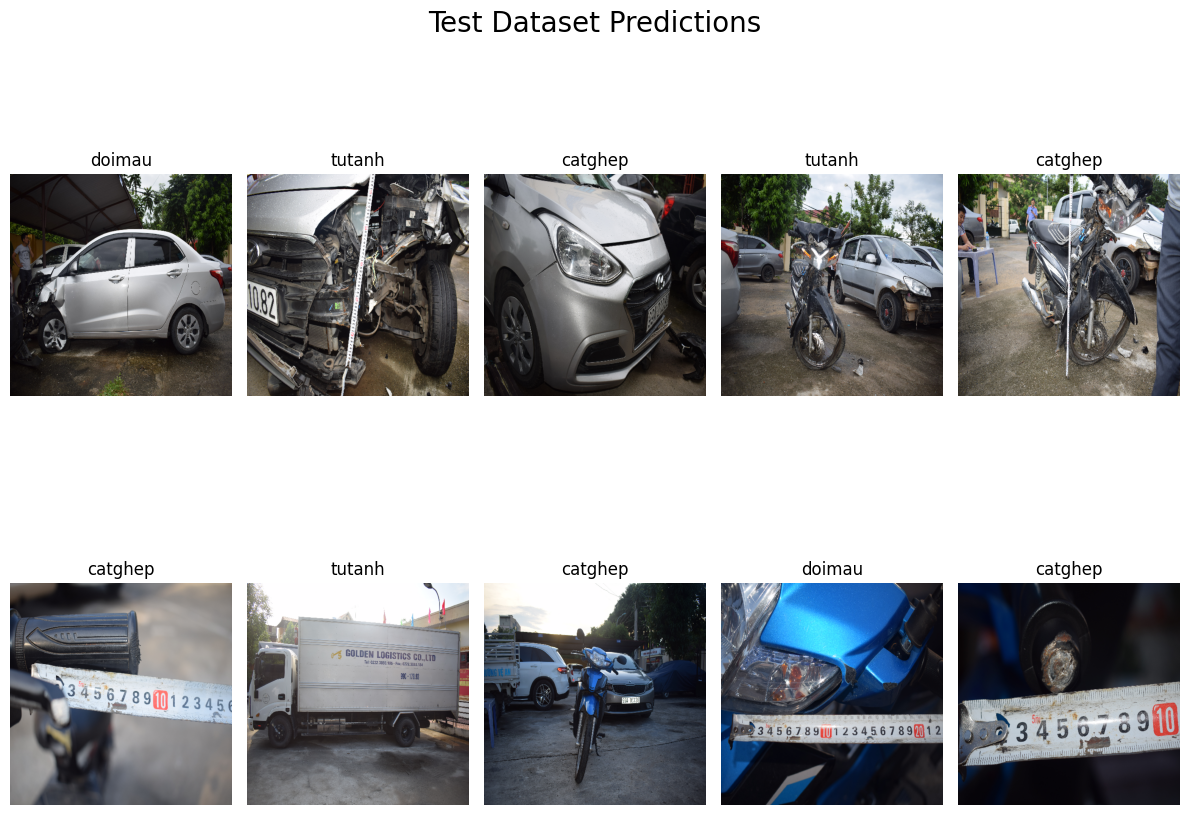

In [28]:
predictions = model.predict(test_generator)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [29]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

21/21 [==============================] - 113s 5s/step - loss: 1.6889 - accuracy: 0.2387
Test Loss:     1.6889259815216064
Test Accuracy: 0.23868954181671143


8. Wrong Predictions

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


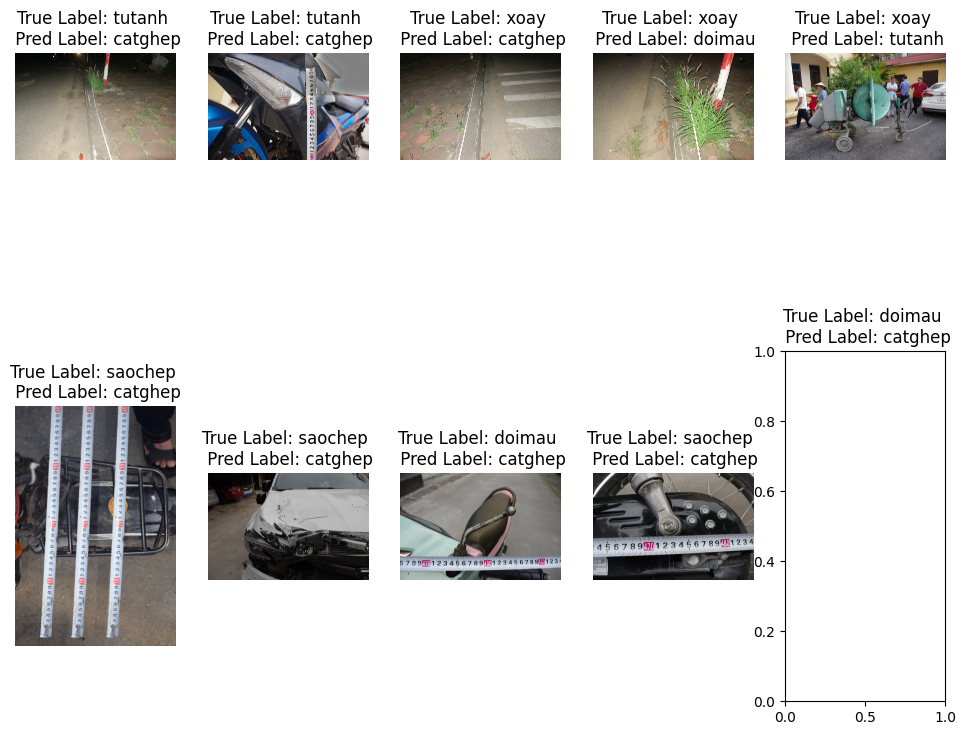

In [37]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Pred Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()